In [1]:
import re
import nltk
import spacy
import random
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# <span style="color:#674ea7"> 💾 Cargar Dataset </span>

In [2]:
comments_data = pd.read_csv('/content/youtoxic_english_1000.csv')
comments_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   CommentId        1000 non-null   object
 1   VideoId          1000 non-null   object
 2   Text             1000 non-null   object
 3   IsToxic          1000 non-null   bool  
 4   IsAbusive        1000 non-null   bool  
 5   IsThreat         1000 non-null   bool  
 6   IsProvocative    1000 non-null   bool  
 7   IsObscene        1000 non-null   bool  
 8   IsHatespeech     1000 non-null   bool  
 9   IsRacist         1000 non-null   bool  
 10  IsNationalist    1000 non-null   bool  
 11  IsSexist         1000 non-null   bool  
 12  IsHomophobic     1000 non-null   bool  
 13  IsReligiousHate  1000 non-null   bool  
 14  IsRadicalism     1000 non-null   bool  
dtypes: bool(12), object(3)
memory usage: 35.3+ KB


## <span style="color:#674ea7"> ⭕ Comprobar valores nulos </span>

In [3]:
print(comments_data.isnull().sum())

CommentId          0
VideoId            0
Text               0
IsToxic            0
IsAbusive          0
IsThreat           0
IsProvocative      0
IsObscene          0
IsHatespeech       0
IsRacist           0
IsNationalist      0
IsSexist           0
IsHomophobic       0
IsReligiousHate    0
IsRadicalism       0
dtype: int64


## <span style="color:#674ea7"> 📊 Análisis estadístico descriptivo </span>

In [4]:
comments_data.describe().T

,count,unique,top,freq
CommentId,1000,1000,UgjBJKQSoQMQ6ngCoAEC,1
VideoId,1000,13,9pr1oE34bIM,274
Text,1000,997,run them over,3
IsToxic,1000,2,False,538
IsAbusive,1000,2,False,647
IsThreat,1000,2,False,979
IsProvocative,1000,2,False,839
IsObscene,1000,2,False,900
IsHatespeech,1000,2,False,862
IsRacist,1000,2,False,875


## <span style="color:#674ea7"> ☝ valores unicos </span>

In [5]:
features = []
n_values = []

for col in comments_data.columns:
    features.append(col)
    n_values.append(comments_data[col].unique())

valores_unicos = pd.DataFrame({'feature': features, 'n_values': n_values})

print(valores_unicos)

            feature                                           n_values
0         CommentId  [Ugg2KwwX0V8-aXgCoAEC, Ugg2s5AzSPioEXgCoAEC, U...
1           VideoId  [04kJtp6pVXI, 4rCweDxDqdw, 5vF4si3hoRA, 8HB18h...
2              Text  [If only people would just take a step back an...
3           IsToxic                                      [False, True]
4         IsAbusive                                      [False, True]
5          IsThreat                                      [False, True]
6     IsProvocative                                      [False, True]
7         IsObscene                                      [False, True]
8      IsHatespeech                                      [False, True]
9          IsRacist                                      [False, True]
10    IsNationalist                                      [False, True]
11         IsSexist                                      [False, True]
12     IsHomophobic                                            [False]
13  Is

## <span style="color:#674ea7"> ✌ valores duplicados </span>

In [6]:
# Check for duplicate comments
duplicate_rows = comments_data[comments_data.duplicated(subset=['Text'], keep=False)]
print("Duplicate rows based on 'Text' column:")
print(duplicate_rows)

# Drop duplicate comments
comments_data.drop_duplicates(subset=['Text'], keep='first', inplace=True)

# Confirm duplicates are removed
print("Number of rows after removing duplicates:", len(comments_data))

# Reindex the DataFrame after dropping duplicates
comments_data.reset_index(drop=True, inplace=True)

Duplicate rows based on 'Text' column:
                      CommentId      VideoId           Text  IsToxic  \
592        UgiXm5jxvkdIxHgCoAEC  cT14IbTDW2c  RUN THEM OVER     True   
642  Ugxen2QgJYhNiRrMegR4AaABAg  cT14IbTDW2c  run them over     True   
657  UgxXtUmfp0rdwXB8qld4AaABAg  cT14IbTDW2c  run them over     True   
677  UgyjhPsMlWKlFNmG-h94AaABAg  cT14IbTDW2c  run them over     True   
699  UgzFZGnqcjZcW7wejI54AaABAg  cT14IbTDW2c  RUN THEM OVER     True   

     IsAbusive  IsThreat  IsProvocative  IsObscene  IsHatespeech  IsRacist  \
592       True     False           True      False         False     False   
642       True      True          False      False         False     False   
657       True     False           True      False         False     False   
677       True     False           True      False         False     False   
699       True     False           True      False         False     False   

     IsNationalist  IsSexist  IsHomophobic  IsReligiousHate

## <span style="color:#674ea7"> 📊 Visualización de datos </span>

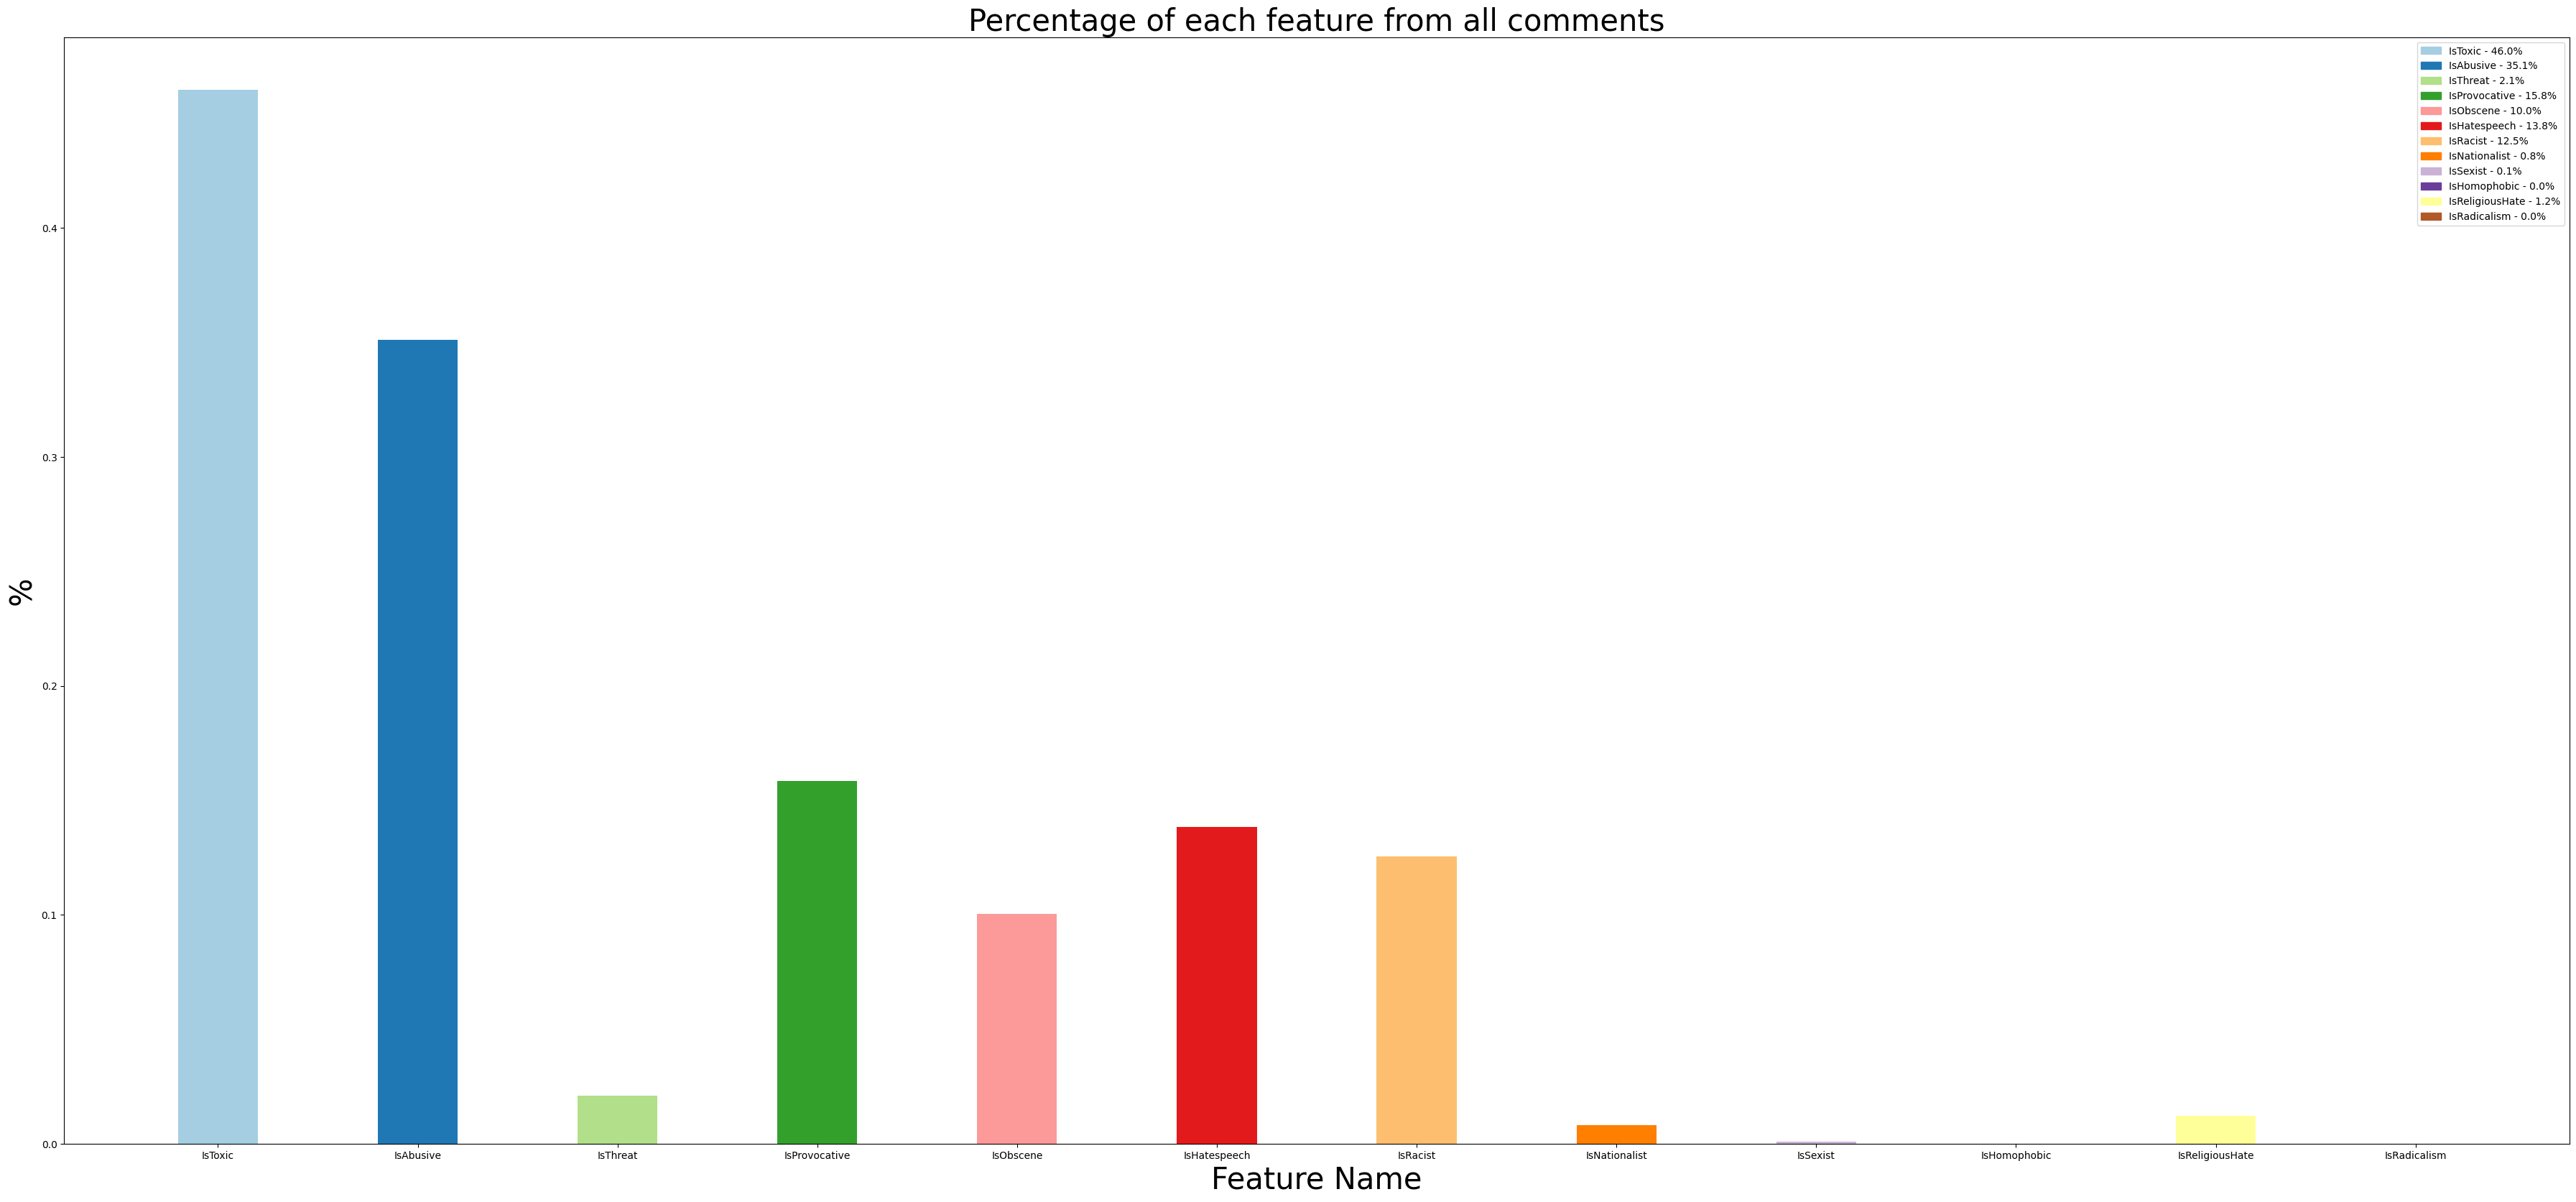

In [7]:
excluded_columns = ['CommentId', 'VideoId', 'Text']
columns_names = [col for col in comments_data.columns if col not in excluded_columns]

bar_data = {}
for name in columns_names:
    bar_data[name] = len(comments_data.loc[comments_data[name] == 1]) / len(comments_data[name])

bar_name = list(bar_data.keys())
values = list(bar_data.values())
fig = plt.figure(figsize=(45, 20))
colors = plt.cm.Paired(np.arange(len(bar_name)))

plt.bar(bar_name, values, color=colors, width=0.4)
plt.xlabel("Feature Name", fontsize=30)
plt.ylabel("""%""", fontsize=30)
plt.title("Percentage of each feature from all comments", fontsize=30)

patch = [mpatches.Patch(color=color, label=f"{bar} - {val*100:.1f}%")
         for color, val, bar in zip(colors, values, bar_name)]
plt.legend(handles=patch)
plt.show()


-----

### <span style="color:#944ea7"> 🧪 Análisis Is Toxic </span>

In [22]:
# Distribution of 'Toxic' column
toxic_distribution = comments_data['IsToxic'].value_counts()
print(toxic_distribution)

IsToxic
False    538
True     459
Name: count, dtype: int64


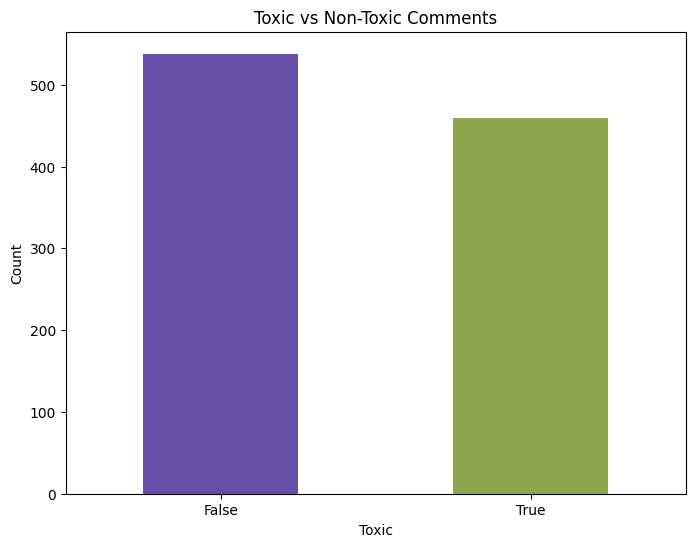

In [35]:
# Bar plot for Toxic vs Non-Toxic Comments
plt.figure(figsize=(8, 6))
toxic_counts = comments_data['IsToxic'].value_counts()
toxic_counts.plot(kind='bar', color=['#674ea7', '#8ea74e'])
plt.title('Toxic vs Non-Toxic Comments')
plt.xlabel('Toxic')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

#### <span style="color:#4e62a7"> ☁ WordCloud </span>

In [48]:
untoxic_comments = comments_data.Text.loc[comments_data.IsToxic==0]
new_untoxic_commentss = untoxic_comments.value_counts().to_frame().head(1000)
full_untoxic_commentss = "".join(new_untoxic_commentss.index.tolist())

toxic_comments = comments_data.Text.loc[comments_data.IsToxic==1]
new_toxic_commentss = toxic_comments.value_counts().to_frame().head(1000)
full_toxic_commentss = "".join(new_toxic_commentss.index.tolist())

wordcloud_untoxic = WordCloud(max_font_size=50, max_words=100,width=500, height=500,
                      background_color="white") \
    .generate(full_untoxic_commentss)

wordcloud_toxic = WordCloud(max_font_size=50, max_words=100,width=500, height=500,
                      background_color="black") \
    .generate(full_toxic_commentss)

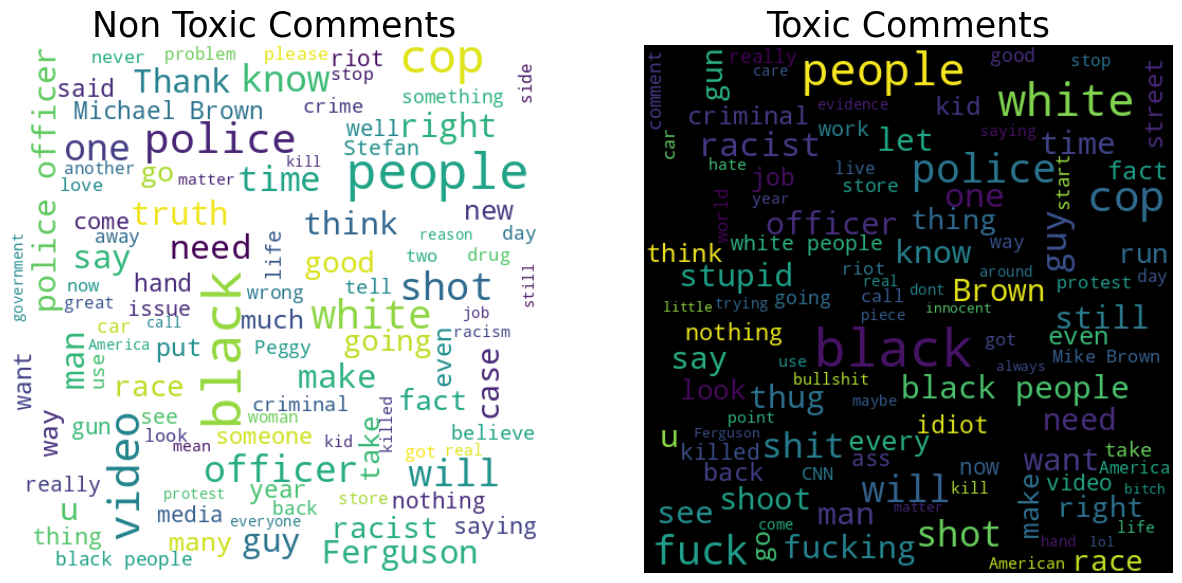

In [49]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(wordcloud_untoxic, interpolation="bilinear")
ax1.axis("off")
ax2.imshow(wordcloud_toxic, interpolation="bilinear")
ax2.axis("off")
ax1.set_title("Non Toxic Comments", fontsize=25)
ax2.set_title("Toxic Comments", fontsize=25)
plt.show()

-----

### <span style="color:#944ea7"> 🚨 Análisis Is Abusive </span>

In [26]:
# Distribution of 'Abusive' column
abusive_distribution = comments_data['IsAbusive'].value_counts()
print(abusive_distribution)

IsAbusive
False    647
True     350
Name: count, dtype: int64


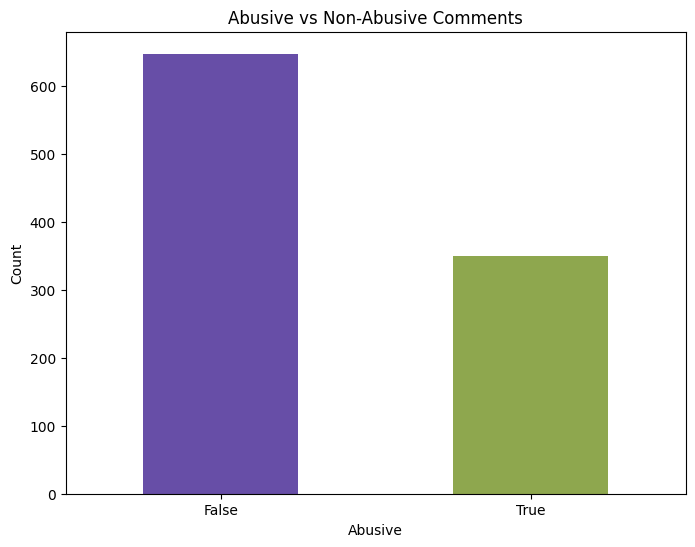

In [36]:
# Bar plot for Abusive vs Non-Abusive Comments
plt.figure(figsize=(8, 6))
abusive_counts = comments_data['IsAbusive'].value_counts()
abusive_counts.plot(kind='bar', color=['#674ea7', '#8ea74e'])
plt.title('Abusive vs Non-Abusive Comments')
plt.xlabel('Abusive')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

#### <span style="color:#4e62a7"> ☁ WordCloud </span>

In [50]:
unabusive_comments = comments_data.Text.loc[comments_data.IsAbusive==0]
new_unabusive_commentss = unabusive_comments.value_counts().to_frame().head(1000)
full_unabusive_commentss = "".join(new_unabusive_commentss.index.tolist())

abusive_comments = comments_data.Text.loc[comments_data.IsAbusive==1]
new_abusive_commentss = abusive_comments.value_counts().to_frame().head(1000)
full_abusive_commentss = "".join(new_abusive_commentss.index.tolist())

wordcloud_unabusive = WordCloud(max_font_size=50, max_words=100,width=500, height=500,
                      background_color="white") \
    .generate(full_unabusive_commentss)

wordcloud_abusive = WordCloud(max_font_size=50, max_words=100,width=500, height=500,
                      background_color="black") \
    .generate(full_abusive_commentss)

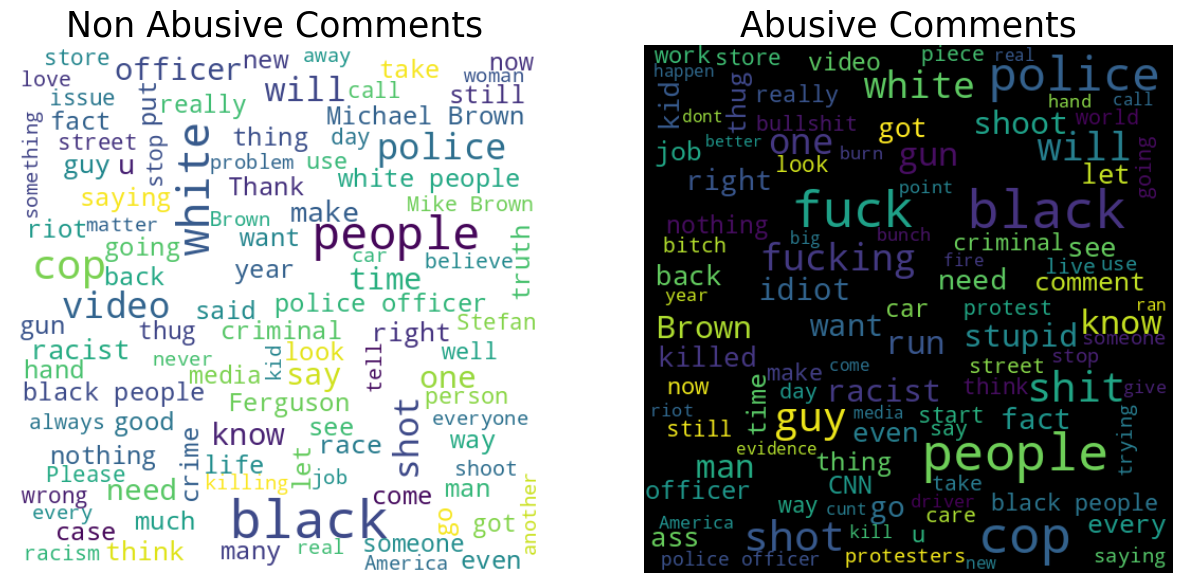

In [55]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(wordcloud_unabusive, interpolation="bilinear")
ax1.axis("off")
ax2.imshow(wordcloud_abusive, interpolation="bilinear")
ax2.axis("off")
ax1.set_title("Non Abusive Comments", fontsize=25)
ax2.set_title("Abusive Comments", fontsize=25)
plt.show()

------

### <span style="color:#944ea7"> 🔪 Análisis Is Threat </span>

In [53]:
# Distribution of 'Threat' column
threat_distribution = comments_data['IsThreat'].value_counts()
print(threat_distribution)

IsThreat
False    976
True      21
Name: count, dtype: int64


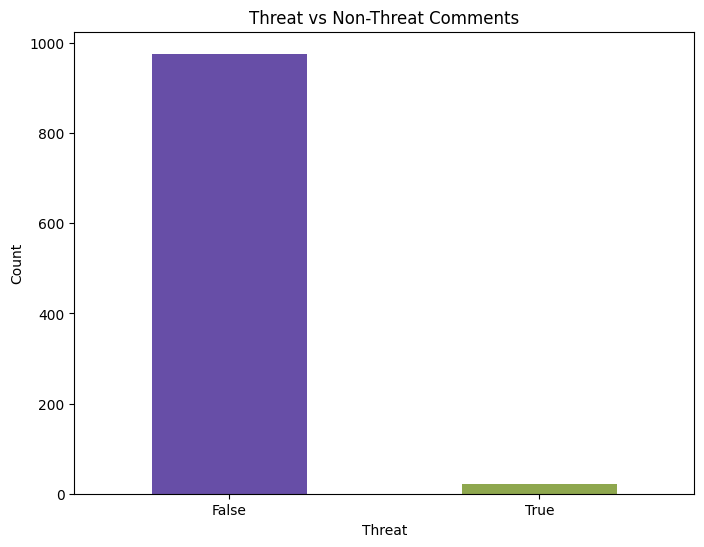

In [56]:
# Bar plot for Threat vs Non-Threat Comments
plt.figure(figsize=(8, 6))
threat_counts = comments_data['IsThreat'].value_counts()
threat_counts.plot(kind='bar', color=['#674ea7', '#8ea74e'])
plt.title('Threat vs Non-Threat Comments')
plt.xlabel('Threat')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

#### <span style="color:#4e62a7"> ☁ WordCloud </span>

In [57]:
unthreat_comments = comments_data.Text.loc[comments_data.IsThreat==0]
new_unthreat_commentss = unthreat_comments.value_counts().to_frame().head(1000)
full_unthreat_commentss = "".join(new_unthreat_commentss.index.tolist())

threat_comments = comments_data.Text.loc[comments_data.IsThreat==1]
new_threat_commentss = threat_comments.value_counts().to_frame().head(1000)
full_threat_commentss = "".join(new_threat_commentss.index.tolist())

wordcloud_unthreat = WordCloud(max_font_size=50, max_words=100,width=500, height=500,
                      background_color="white") \
    .generate(full_unthreat_commentss)

wordcloud_threat = WordCloud(max_font_size=50, max_words=100,width=500, height=500,
                      background_color="black") \
    .generate(full_threat_commentss)

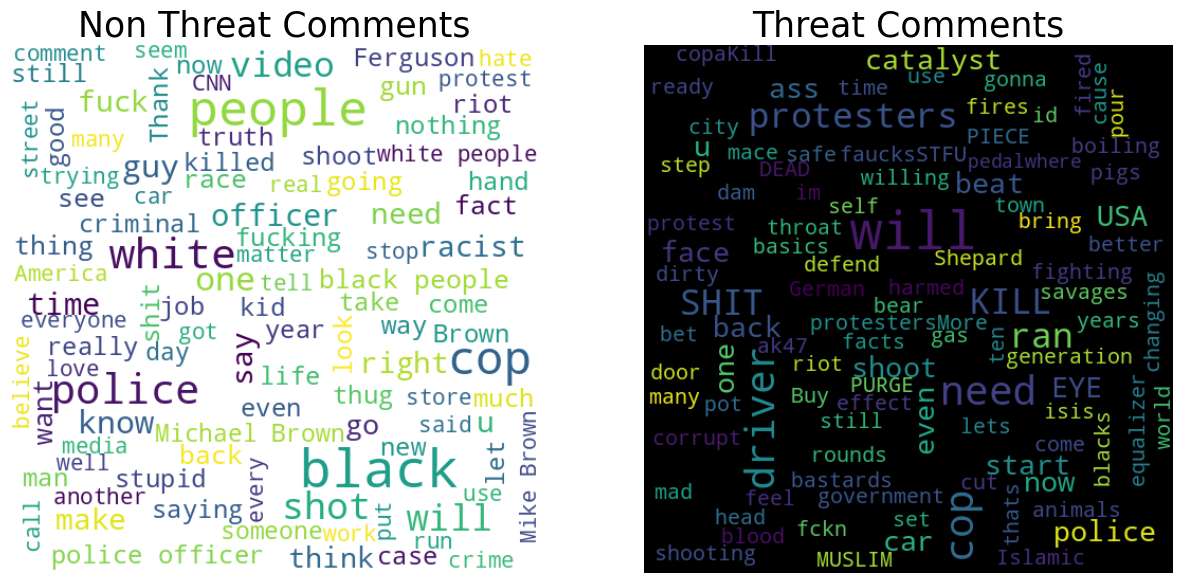

In [58]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(wordcloud_unthreat, interpolation="bilinear")
ax1.axis("off")
ax2.imshow(wordcloud_threat, interpolation="bilinear")
ax2.axis("off")
ax1.set_title("Non Threat Comments", fontsize=25)
ax2.set_title("Threat Comments", fontsize=25)
plt.show()

-----

### <span style="color:#944ea7"> 🪃 Análisis Is Provocative </span>

In [59]:
# Distribution of 'Provocative' column
provocative_distribution = comments_data['IsProvocative'].value_counts()
print(provocative_distribution)

IsProvocative
False    839
True     158
Name: count, dtype: int64


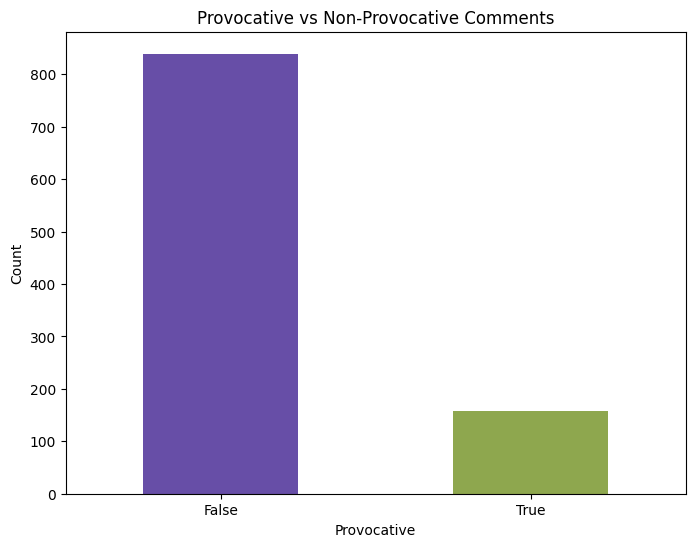

In [72]:
# Bar plot for Provocative vs Non-ProvocativeComments
plt.figure(figsize=(8, 6))
provocative_counts = comments_data['IsProvocative'].value_counts()
provocative_counts.plot(kind='bar', color=['#674ea7', '#8ea74e'])
plt.title('Provocative vs Non-Provocative Comments')
plt.xlabel('Provocative')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

#### <span style="color:#4e62a7"> ☁ WordCloud </span>

In [62]:
unprovocative_comments = comments_data.Text.loc[comments_data.IsProvocative==0]
new_unprovocative_commentss = unprovocative_comments.value_counts().to_frame().head(1000)
full_unprovocative_commentss = "".join(new_unprovocative_commentss.index.tolist())

provocative_comments = comments_data.Text.loc[comments_data.IsProvocative==1]
new_provocative_commentss = provocative_comments.value_counts().to_frame().head(1000)
full_provocative_commentss = "".join(new_provocative_commentss.index.tolist())

wordcloud_unprovocative = WordCloud(max_font_size=50, max_words=100,width=500, height=500,
                      background_color="white") \
    .generate(full_unprovocative_commentss)

wordcloud_provocative = WordCloud(max_font_size=50, max_words=100,width=500, height=500,
                      background_color="black") \
    .generate(full_provocative_commentss)

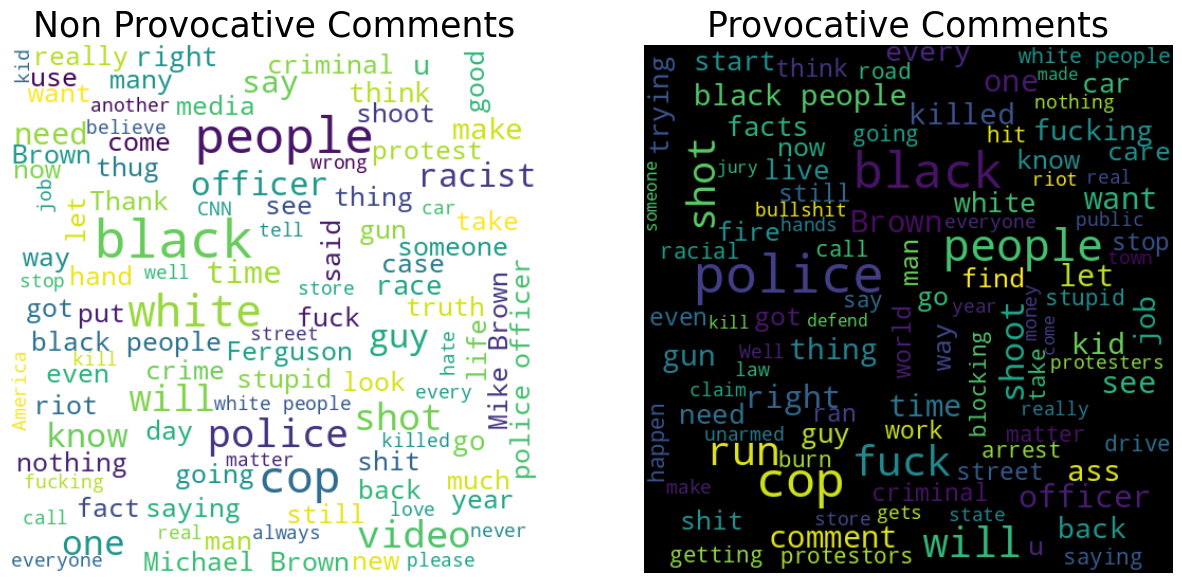

In [73]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(wordcloud_unprovocative, interpolation="bilinear")
ax1.axis("off")
ax2.imshow(wordcloud_provocative, interpolation="bilinear")
ax2.axis("off")
ax1.set_title("Non Provocative Comments", fontsize=25)
ax2.set_title("Provocative Comments", fontsize=25)
plt.show()

----

### <span style="color:#944ea7"> ❌ Análisis Is Obscene </span>

In [65]:
# Distribution of 'Obscene' column
obscene_distribution = comments_data['IsObscene'].value_counts()
print(obscene_distribution)

IsObscene
False    897
True     100
Name: count, dtype: int64


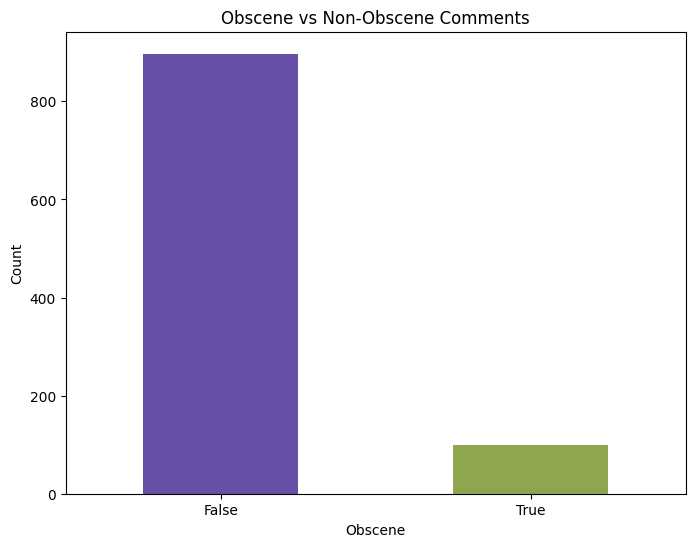

In [67]:
# Bar plot for Obscene vs Non-Obscene Comments
plt.figure(figsize=(8, 6))
obscene_counts = comments_data['IsObscene'].value_counts()
obscene_counts.plot(kind='bar', color=['#674ea7', '#8ea74e'])
plt.title('Obscene vs Non-Obscene Comments')
plt.xlabel('Obscene')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

#### <span style="color:#4e62a7"> ☁ WordCloud </span>

In [74]:
unobscene_comments = comments_data.Text.loc[comments_data.IsObscene==0]
new_unobscene_commentss = unobscene_comments.value_counts().to_frame().head(1000)
full_unobscene_commentss = "".join(new_unobscene_commentss.index.tolist())

obscene_comments = comments_data.Text.loc[comments_data.IsObscene==1]
new_obscene_commentss = obscene_comments.value_counts().to_frame().head(1000)
full_obscene_commentss = "".join(new_obscene_commentss.index.tolist())

wordcloud_unobscene = WordCloud(max_font_size=50, max_words=100,width=500, height=500,
                      background_color="white") \
    .generate(full_unobscene_commentss)

wordcloud_obscene = WordCloud(max_font_size=50, max_words=100,width=500, height=500,
                      background_color="black") \
    .generate(full_obscene_commentss)

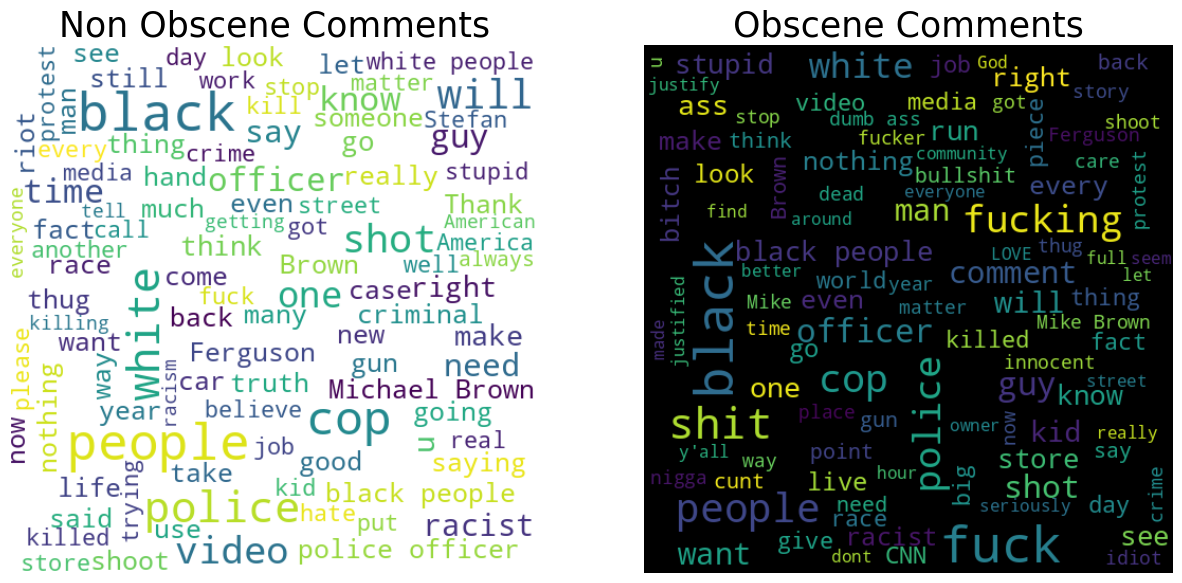

In [75]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(wordcloud_unobscene, interpolation="bilinear")
ax1.axis("off")
ax2.imshow(wordcloud_obscene, interpolation="bilinear")
ax2.axis("off")
ax1.set_title("Non Obscene Comments", fontsize=25)
ax2.set_title("Obscene Comments", fontsize=25)
plt.show()

-----

In [52]:
comments_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997 entries, 0 to 996
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   CommentId        997 non-null    object
 1   VideoId          997 non-null    object
 2   Text             997 non-null    object
 3   IsToxic          997 non-null    bool  
 4   IsAbusive        997 non-null    bool  
 5   IsThreat         997 non-null    bool  
 6   IsProvocative    997 non-null    bool  
 7   IsObscene        997 non-null    bool  
 8   IsHatespeech     997 non-null    bool  
 9   IsRacist         997 non-null    bool  
 10  IsNationalist    997 non-null    bool  
 11  IsSexist         997 non-null    bool  
 12  IsHomophobic     997 non-null    bool  
 13  IsReligiousHate  997 non-null    bool  
 14  IsRadicalism     997 non-null    bool  
dtypes: bool(12), object(3)
memory usage: 35.2+ KB


### <span style="color:#944ea7"> Análisis Is Nationalist </span>

In [ ]:
# Distribution of 'Nationalist' column
Nationalist_distribution = comments_data['IsNationalist'].value_counts()
print(Nationalist_distribution)

In [ ]:
# Bar plot for Nationalist vs Non-Nationalist Comments
plt.figure(figsize=(8, 6))
toxic_counts = comments_data['IsNationalist'].value_counts()
toxic_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Nationalist vs Non-Nationalist Comments')
plt.xlabel('Nationalist')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [ ]:
# Word Cloud for Nationalist vs Non-Nationalist Comments
nationalist_comments = ' '.join(comments_data[comments_data['IsNationalist']]['Text'])
wordcloud_toxic = WordCloud(width=800, height=400, background_color='white').generate(nationalist_comments)
plt.imshow(wordcloud_toxic, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Nationalist Comments')
plt.show()

In [ ]:
non_toxic_comments = ' '.join(comments_data[~comments_data['IsNationalist']]['Text'])
wordcloud_non_toxic = WordCloud(width=800, height=400, background_color='white').generate(non_toxic_comments)
plt.imshow(wordcloud_non_toxic, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Nationalist Comments')
plt.show()

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [ ]:
comments_data['Text'] = comments_data['Text'].apply(clean_text)

In [ ]:
comments_data

In [40]:
nationalist_comments = comments_data.loc[comments_data['IsNationalist'] == 1, 'Text']
print(nationalist_comments)

224    USA land of the free baby. HAHAHAHA! All you p...
227             no dumber people on earth then americans
363    +Stefan Molyneux \t \t \t \t\nWhy do you hate ...
644    California is so stupid ! Just arrest all them...
674    These Californians deserve this backup since t...
706                                      Stupid American
875                                   It's only Ameland!
933    United Shits Of America is collapsing. this is...
Name: Text, dtype: object


In [41]:
nationalist_comments = comments_data.loc[comments_data['IsNationalist'] == 0, 'Text']
print(nationalist_comments)

0      If only people would just take a step back and...
1      Law enforcement is not trained to shoot to app...
2      \nDont you reckon them 'black lives matter' ba...
3      There are a very large number of people who do...
4      The Arab dude is absolutely right, he should h...
                             ...                        
992    I remember that they sent in the national defe...
993    Stats don`t represent the problem. Race baitin...
994    The quote from the mother... Wow that hit hard...
995                              this video is so racist
996        God, the narrator has such an annoying lisp. 
Name: Text, Length: 989, dtype: object


In [42]:
# export_data = comments_data[['Text', 'IsNationalist']]
# export_data.to_csv('nationalist_comments.csv', index=False, sep=';', encoding='utf-8')